# Encoding data

In general, SciKit learn only processes numerical data (with some rare exceptions).  Therefore it's necessary to encode categorical data prior to the application of any of the ML algorithms from sklearn.  However, there are several considerations that will impact your data processing.

#### Label Encoding: When Not to Use It

Label encoding transforms categorical data into integer values (e.g., 'red' -> 0, 'blue' -> 1, 'green' -> 2). While this is convenient, it's not suitable for non-ordinal categorical variables (variables that don't have a natural order) when using certain algorithms like Logistic Regression.  Note that label encoding is generally ok for Decision Trees (we'll talk about these later).

##### Example: Why LabelEncoding Messes Up ML

Consider a synthetic dataset with two clear clusters:


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


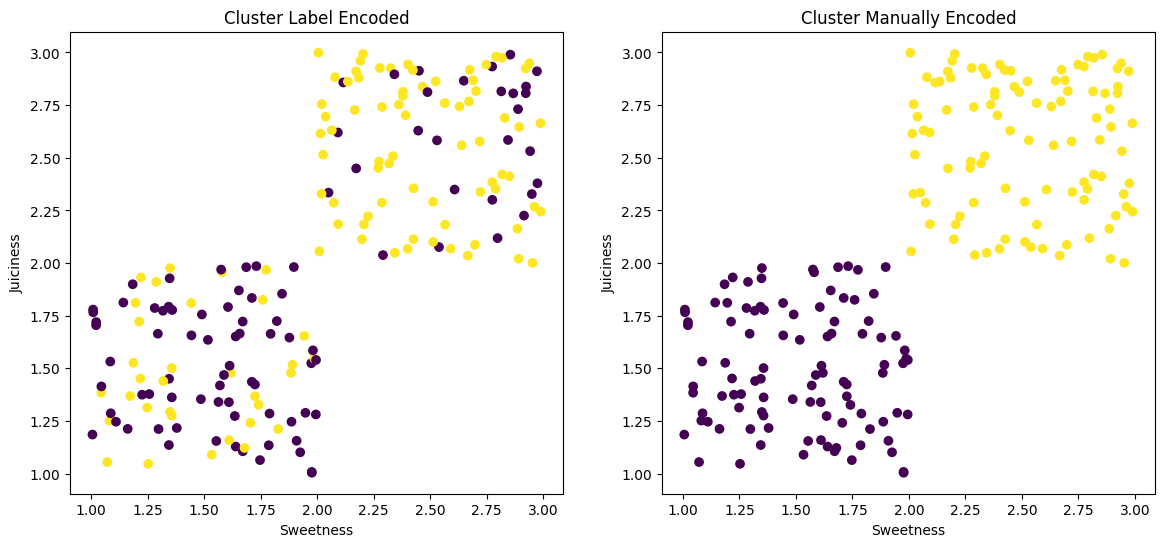

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Generate synthetic data
n_samples = 100
sweet_juicy = np.random.uniform(2, 3, (n_samples, 2))
not_sweet_not_juicy = np.random.uniform(1, 2, (n_samples, 2))

# Assign colors (ordinal labels should coincide with the natural clusters)
colors_sweet_juicy = np.random.choice(['Blue', 'Orange', 'Purple'], n_samples)
colors_not_sweet_not_juicy = np.random.choice(['Green', 'Pink', 'Red'], n_samples)

# Combine data
X = np.vstack([sweet_juicy, not_sweet_not_juicy])
colors = np.concatenate([colors_sweet_juicy, colors_not_sweet_not_juicy])

# Create DataFrame
df = pd.DataFrame(X, columns=['Sweetness', 'Juiciness'])
df['Color'] = colors

# Label encode (alphabetic)
le1 = LabelEncoder()
df['Color_auto_encoded'] = le1.fit_transform(df['Color'])
# Label encode (manual)
color_mapping = {'Blue': 0, 'Orange': 1, 'Purple': 2, 'Green': 3, 'Pink': 4, 'Red': 5}
df['Color_manual_encoded'] = df['Color'].map(color_mapping)

# Perform k-means clustering with auto-encoded labels
kmeans_auto = KMeans(n_clusters=2, random_state=0)
df['Cluster_auto_encoded'] = kmeans_auto.fit_predict(df[['Sweetness', 'Juiciness','Color_auto_encoded']])

# Perform k-means clustering with manually assigned labels
kmeans_manual = KMeans(n_clusters=2, random_state=0)
df['Cluster_manual_encoded'] = kmeans_manual.fit_predict(df[['Sweetness', 'Juiciness','Color_manual_encoded']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_auto_encoded'], cmap='viridis')
axes[0].set_title('Cluster Label Encoded')
axes[0].set_xlabel('Sweetness')
axes[0].set_ylabel('Juiciness')

axes[1].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_manual_encoded'], cmap='viridis')
axes[1].set_title('Cluster Manually Encoded')
axes[1].set_xlabel('Sweetness')
axes[1].set_ylabel('Juiciness')

plt.show()


Here, the auto-encoding assigns values in alphabetic order, which conflicts with the natural clustering in the other dimensions.  Reassigning the encoding differently leads to a different result, even though the data didn't change.



#### One-Hot Encoding: A Better Alternative

For non-ordinal categorical variables, it's usually better to use one-hot encoding. This creates a binary column for each category and indicates the presence of the categories with a 1 or 0.  For example:

##### Table with Categorical Column

| Index | Color  |
|-------|--------|
| 0     | Red    |
| 1     | Blue   |
| 2     | Green  |
| 3     | Red    |
| 4     | Green  |

##### Table after One-Hot Encoding

| Index | Color_Red | Color_Blue | Color_Green |
|-------|-----------|------------|-------------|
| 0     | 1         | 0          | 0           |
| 1     | 0         | 1          | 0           |
| 2     | 0         | 0          | 1           |
| 3     | 1         | 0          | 0           |
| 4     | 0         | 0          | 1           |

However, when one-hot encoding, you'll note that if you know two of the columns, you automatically know the value of the third.  This is sometimes referred to as the "dummy variable trap," and creates something called "multicolinearity," which cause problems for learners (like linear regression).  Therefore, it is usually the case that one of the columns is dropped, like:

##### Table after One-Hot Encoding with `Color_Red` dropped.

| Index | Color_Blue | Color_Green |
|-------|------------|-------------|
| 0     | 0          | 0           |
| 1     | 1          | 0           |
| 2     | 0          | 1           |
| 3     | 0          | 0           |
| 4     | 0          | 1           |

Both `pd.get_dummies()` and Scikit-Learn's `OneHotEncoder` serve the same fundamental purpose: they convert categorical data into a format that can be provided to machine learning algorithms, typically in the form of one-hot encoding. However, they do have differences, and each comes with its own set of advantages and disadvantages.

#### Flexibility with Data Types:

- `pd.get_dummies()`: Handles string labels directly.
- `OneHotEncoder`: Only handles string labels if you set `handle_unknown='ignore'`.

#### Handling Unknown Categories:

- `pd.get_dummies()`: Doesn't handle unknown categories in the test data by default. You have to manage this manually.
- `OneHotEncoder`: Can handle unknown categories in test data by setting `handle_unknown='ignore'`.

#### Output Type:

- `pd.get_dummies()`: Returns a DataFrame.
- `OneHotEncoder`: Returns a NumPy array or sparse matrix.

#### Feature Names:

- `pd.get_dummies()`: Directly gives a DataFrame with meaningful column names.
- `OneHotEncoder`: Feature names can be retrieved, but it's not as straightforward as with `get_dummies()`.

#### Imputation:

- `pd.get_dummies()`: Doesn't support missing values.
- `OneHotEncoder`: Doesn't support missing values either, but can work alongside Scikit-Learn's imputation tools, as it is part of the same ecosystem.

#### Pipeline:

- `pd.get_dummies()`: Can't be included in a Scikit-Learn `Pipeline`.
- `OneHotEncoder`: Can be part of a Scikit-Learn `Pipeline`, making it more convenient for model selection and tuning.

### Which is Preferred and Why?

- **For Quick Exploration or Prototyping**: `pd.get_dummies()` is often quicker and easier to use for one-off tasks. 
- **For Production or Pipelined Tasks**: `OneHotEncoder` is usually the choice when building end-to-end machine learning pipelines or when you need better handling of edge cases, like unknown categories in test data.

So, the "best" method depends on the specifics of what you're trying to accomplish. If you're working solely within the Pandas ecosystem for a quick data analysis, `pd.get_dummies()` might be all you need. But if you're developing a machine learning pipeline that will go into production, or if you want more control over the behavior of the encoder, then Scikit-Learn's `OneHotEncoder` is generally more suitable.  In this class, we'll focus on using sci-kit learn's OneHotEncoder.


### Example

/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


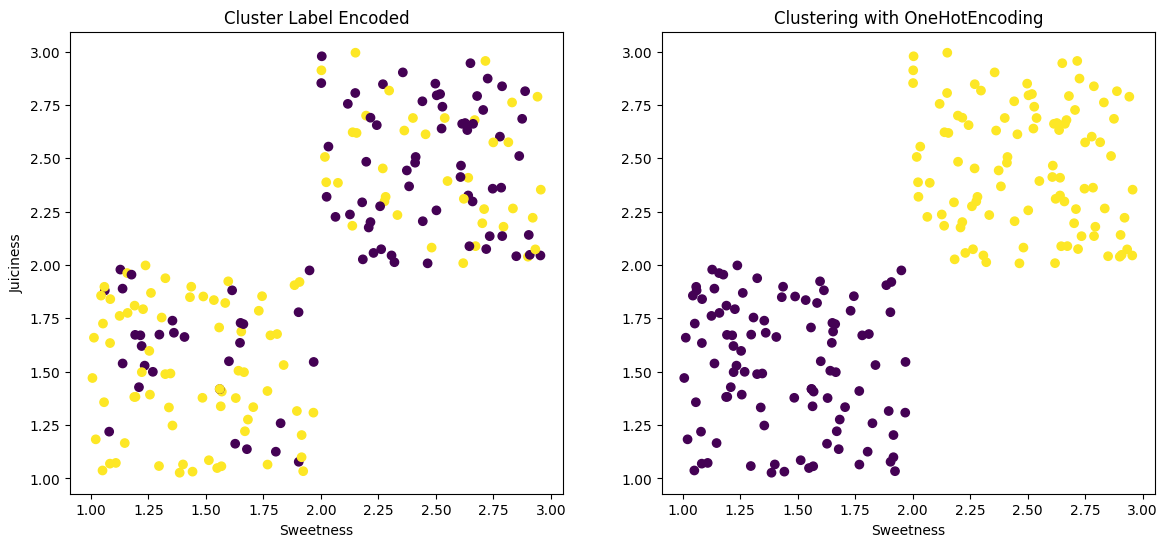

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Generate synthetic data
n_samples = 100
sweet_juicy = np.random.uniform(2, 3, (n_samples, 2))
not_sweet_not_juicy = np.random.uniform(1, 2, (n_samples, 2))

# Assign colors (ordinal labels should coincide with the natural clusters)
colors_sweet_juicy = np.random.choice(['Blue', 'Orange', 'Purple'], n_samples)
colors_not_sweet_not_juicy = np.random.choice(['Green', 'Pink', 'Red'], n_samples)

# Combine data
X = np.vstack([sweet_juicy, not_sweet_not_juicy])
colors = np.concatenate([colors_sweet_juicy, colors_not_sweet_not_juicy])

# Create DataFrame
df = pd.DataFrame(X, columns=['Sweetness', 'Juiciness'])
df['Color'] = colors

# OneHotEncoding
# Note the "spare=False" - this is necessary because we are converting the encoded matrix
# back into a DataFrame
encoder = OneHotEncoder(sparse=False)

colors_one_hot = encoder.fit_transform(df[['Color']])
df_one_hot = pd.DataFrame(colors_one_hot, columns=encoder.get_feature_names_out(['Color']))

# Combine the original dataframe with one-hot-encoded dataframe
df_combined = pd.concat([df, df_one_hot], axis=1)

# Label encode (alphabetic)
le1 = LabelEncoder()
df['Color_auto_encoded'] = le1.fit_transform(df['Color'])

# Perform k-means clustering with auto-encoded labels
kmeans_auto = KMeans(n_clusters=2, random_state=0)
df['Cluster_auto_encoded'] = kmeans_auto.fit_predict(df[['Sweetness', 'Juiciness','Color_auto_encoded']])


# Performing k-means clustering with one-hot-encoded labels
kmeans_one_hot = KMeans(n_clusters=2, random_state=0)
df_combined['Cluster_one_hot_encoded'] = kmeans_one_hot.fit_predict(df_combined.drop(['Color'], axis=1))

# Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_auto_encoded'], cmap='viridis')
axes[0].set_title('Cluster Label Encoded')
axes[0].set_xlabel('Sweetness')
axes[0].set_ylabel('Juiciness')


axes[1].scatter(df_combined['Sweetness'], df_combined['Juiciness'], c=df_combined['Cluster_one_hot_encoded'], cmap='viridis')
axes[1].set_title('Clustering with OneHotEncoding')
axes[1].set_xlabel('Sweetness')
axes[1].set_label('Juiciness')

plt.show()


Note the `sparse=False` in the above code.  Notice what happens if we don't do this.

In [3]:
X = [['red'], ['blue'], ['green']]

encoder_sparse = OneHotEncoder()
sparse_output = encoder_sparse.fit_transform(X)

pd.DataFrame(sparse_output,columns=encoder_sparse.get_feature_names_out(['Color']))

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)

This is is because the OneHotEncoder returns a `sparse` matrix by default, which is a memory efficient format for matrices with lots of `0`s.  This cannot be directly converted to a pandas DataFrame with the desired shape, yielding a mismatch between the number of labels and the size of the DataFrame.

### Applying One-hot encoding to multiple columns

Although you can apply one-hot encoding on a column by column basis, it is often the case that you will have to apply it to multiple columns.  One way to do this is to loop through the columns you care about, and apply one-hot encoding to each in turn.  This would look like:

In [5]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your DataFrame
# Initialize an empty DataFrame to hold the transformed columns
df_transformed = pd.DataFrame()

# Loop through each column in the original DataFrame
for col in df.columns:
    # Check if the column is of object or category type
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse=False, drop='first')
        
        # Fit and transform the column and convert it to a DataFrame
        one_hot_encoded = encoder.fit_transform(df[[col]])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([col]))
        
        # Concatenate the one-hot-encoded DataFrame to the transformed DataFrame
        df_transformed = pd.concat([df_transformed, one_hot_df], axis=1)
    else:
        # If the column is not categorical, just copy it to the transformed DataFrame
        df_transformed[col] = df[col].copy()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
